# Exploitation

Goal is to exploit a model we trained to detect faces.

In [1]:
import cv2 as cv
import numpy as np
import sys
import torch
import torchvision
import torchvision.transforms as T
from cv2 import IMREAD_GRAYSCALE, IMREAD_COLOR
from deep_learning_project.load_data import get_transform
from deep_learning_project.net import LinearRegressionNetwork, SecondNeuralNetwork
from torch import nn
from torchvision.transforms import InterpolationMode
import math
import matplotlib.pyplot as plt

c:\python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading the model.

Models are stocked in the models/ folder.

The right model must be instanciated !

In [2]:
model = SecondNeuralNetwork()

model.load_state_dict(torch.load('models/20221114_0029_SecondNeuralNetwork/best_test_weights.pt'))
model.eval()

classes = ['noface', 'face']

In [3]:
def predict(model, img):
    obj = None
    with torch.no_grad():
        # exploit the model
        logits = model(img)
        pred_probab = nn.Softmax(dim=1)(logits)
        y_pred = pred_probab.argmax(1).item() # indice(s) of the maximum value in the tensor
        obj = (y_pred, pred_probab)
    return obj

# Finding faces on an image

We load an image both color and greyscale.

In [4]:
# Image
img_src = cv.samples.findFile("image.jpg")

img = cv.imread(img_src, IMREAD_GRAYSCALE)
img_color = cv.imread(img_src, IMREAD_COLOR)

print(img_color.shape)

(3024, 2268, 3)


We have to transform the image in a comprehensible way for the neural network. (do we ?)

For that, we take the transformation used in the training. (get_transform()).
Because we loaded the image through OpenCV and not PyTorch we have to transform the numpy format (H x W x C) into the PIL format with the ToPILImage transformation.

In [5]:
# Transform the image
transform = get_transform()

transformed_image = transform(T.ToPILImage()(img_color))
print(transformed_image.shape)

torch.Size([1, 3024, 2268])


Now we have to find the faces in the image !

We are implementing a sliding windows that move on the whole image. The windows (=retina) is 36x36 pixels. In order to, find faces of all sizes we have to find to do it on multiple scale.

For each scale, we will get an image of the prediction the neural network made (yes or no for that pixel).
So we have to aggregate the result of each scale's image to one. Meaning we have to upscale the image.
Then we will have to find "blob" in these image. Also we have to filter false alarm.

False alarm can be filtered by considering the volume of the blob. False alarm tends to be smaller than True Positive.

In [6]:
# scale = 0.8

# while (True):
#     new_height = transformed_image.size()[1] * scale
#     new_width = transformed_image.size()[2] * scale

#     # stop the loop if the image is smaller than the retina
#     if new_height < 36 and new_width < 36:
#         break

#     transformed_image = T.Resize((math.ceil(new_height), math.ceil(new_width)), interpolation=InterpolationMode.BILINEAR)(transformed_image)

In [7]:
image = transformed_image.clone()
images = []

scale = 0.8
threshold = 1
stride = 4

feature_maps = []

while (True):
    images.append(image)
    feature_map = []
    for y in range(0, image.size()[1] - 36, stride):

        feature_row = []
        for x in range(0, image.size()[2] - 36, stride):

            # crop and preparing the cropped image
            new_img = image[:, y:y+36, x:x+36]
            new_img = new_img.reshape((1, 1, 36, 36))

            (y_pred, pred_probab) = predict(model, new_img)
            
            # 0 = noface, 1 = face
            if(y_pred == 1 and (threshold == None or pred_probab.squeeze()[1] >= threshold)):
                feature_row.append(True)
                cv.rectangle(img_color, (x,y), (x+36,y+36), (255, 0, 0))
            else:
                feature_row.append(False)

        feature_map.append(feature_row)

    feature_maps.append(feature_map)
    
    new_height = math.ceil(image.size()[1] * scale)
    new_width = math.ceil(image.size()[2] * scale)

    # stop the loop if the image is smaller than the retina
    if new_height < 36 or new_width < 36:
        break

    image = T.Resize((new_height, new_width), interpolation=InterpolationMode.BILINEAR)(image)

In [8]:
print("There are {0} boolean image.".format(len(feature_maps)))

for i, map in enumerate(feature_maps):
    print("map {0} is of size {1} x {2}".format(i, len(map), len(map[0])))

There are 19 boolean image.
map 0 is of size 747 x 558
map 1 is of size 596 x 445
map 2 is of size 475 x 354
map 3 is of size 379 x 282
map 4 is of size 301 x 224
map 5 is of size 239 x 177
map 6 is of size 190 x 140
map 7 is of size 150 x 111
map 8 is of size 119 x 87
map 9 is of size 93 x 68
map 10 is of size 73 x 53
map 11 is of size 57 x 40
map 12 is of size 44 x 31
map 13 is of size 33 x 23
map 14 is of size 25 x 17
map 15 is of size 18 x 12
map 16 is of size 13 x 8
map 17 is of size 9 x 4
map 18 is of size 5 x 2


Visualizing found feature maps.

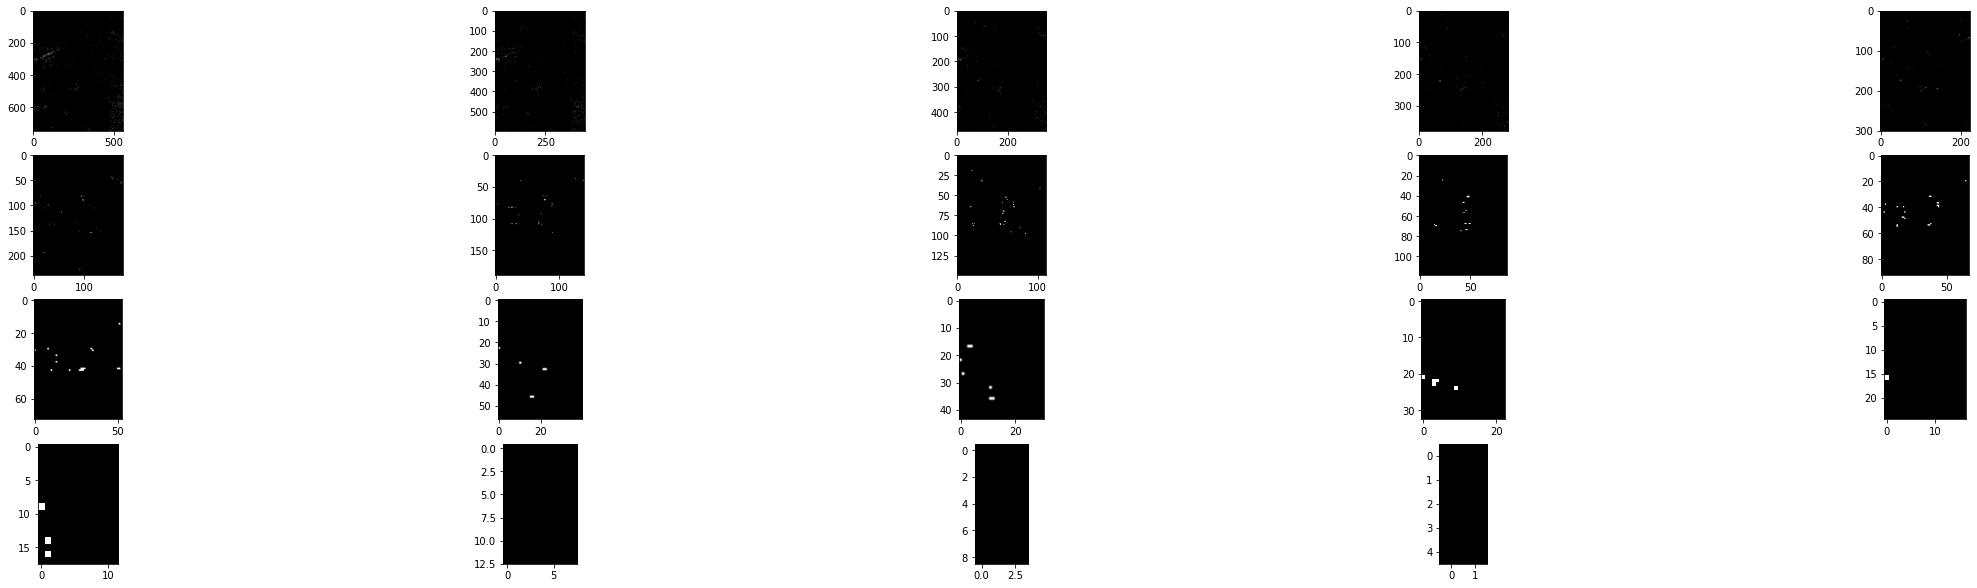

In [9]:
fig = plt.figure(figsize=(40, 50))
rows = math.ceil(len(feature_maps))
cols = 5

feature_maps_contours = []

for i in range(0, len(feature_maps)):
    map = feature_maps[i]
    # Adds a subplot at the 1st position
    fig.add_subplot(rows, cols, i+1)
    
    # showing image
    image = torch.tensor(map)

    image = image.reshape(len(map), len(map[0]), 1).numpy()
    image = image*255
    image = image.astype(np.uint8) # cv rectangle only accepts np.uint8 https://stackoverflow.com/questions/71762449/error-opencv4-5-4-1-error-5bad-argument-in-function-gaussianblur
    
    # finding contours of boids in the feature map
    # contours, hierarchy = cv.findContours(image, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    # for x in contours:
    #     print(cv.boundingRect(x))

    plt.imshow(image, cmap='gray', vmin=0, vmax=255)

plt.show()

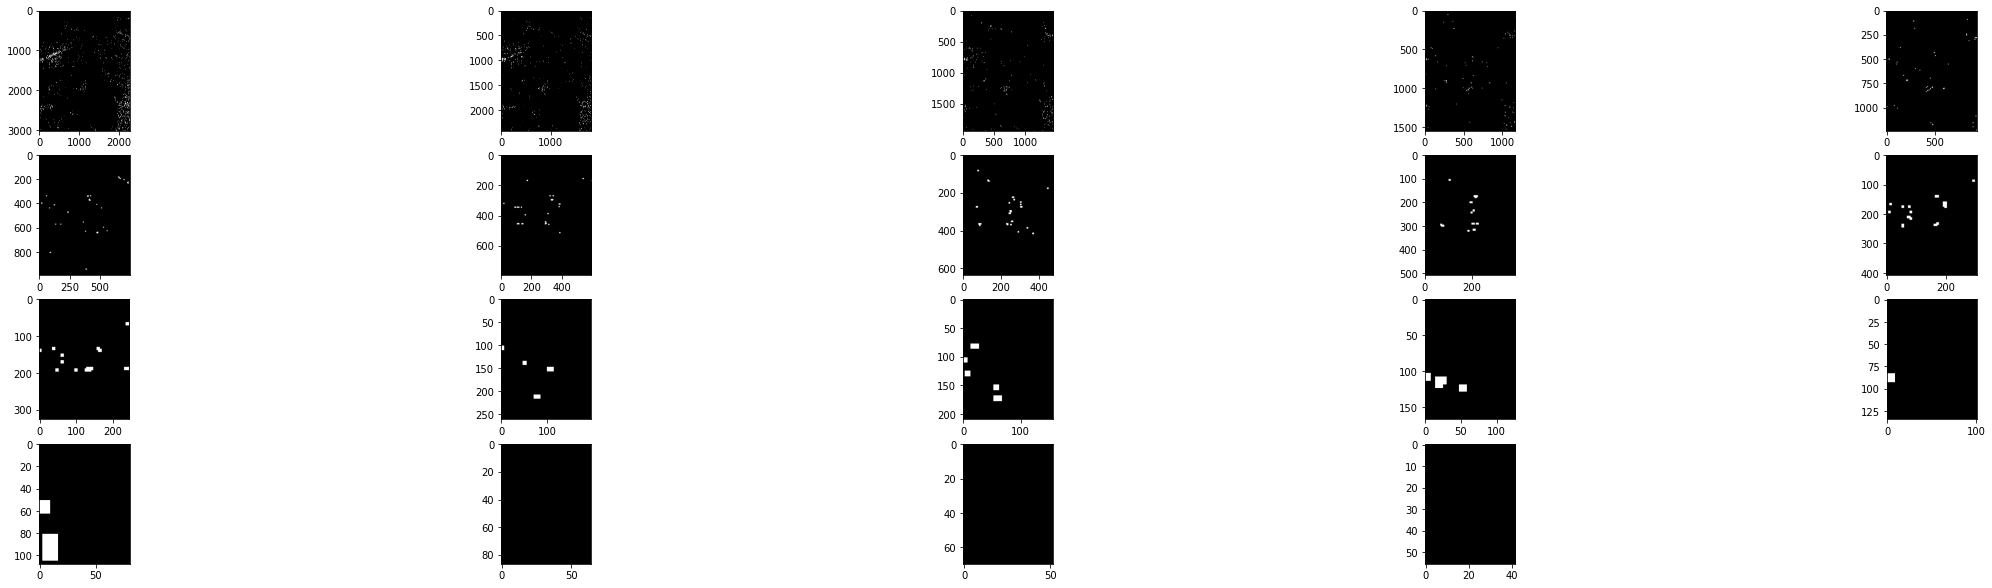

In [10]:
fig = plt.figure(figsize=(40, 50))
rows = math.ceil(len(images))
cols = 5

for i in range(0, len(images)):
    image = images[i]

    # Adds a subplot at the 1st position
    fig.add_subplot(rows, cols, i+1)
    
    # feature_map
    feature = torch.tensor(feature_maps[i])
    feature = feature.reshape((1, feature.size()[0], feature.size()[1]))
    feature = T.Resize((image.size()[1], image.size()[2]), interpolation=InterpolationMode.BILINEAR)(feature)

    feature = feature.permute(1, 2, 0).numpy()
    feature = feature*255
    feature = feature.astype(np.uint8)

    plt.imshow(feature, cmap='gray', vmin=0, vmax=255)

plt.show()

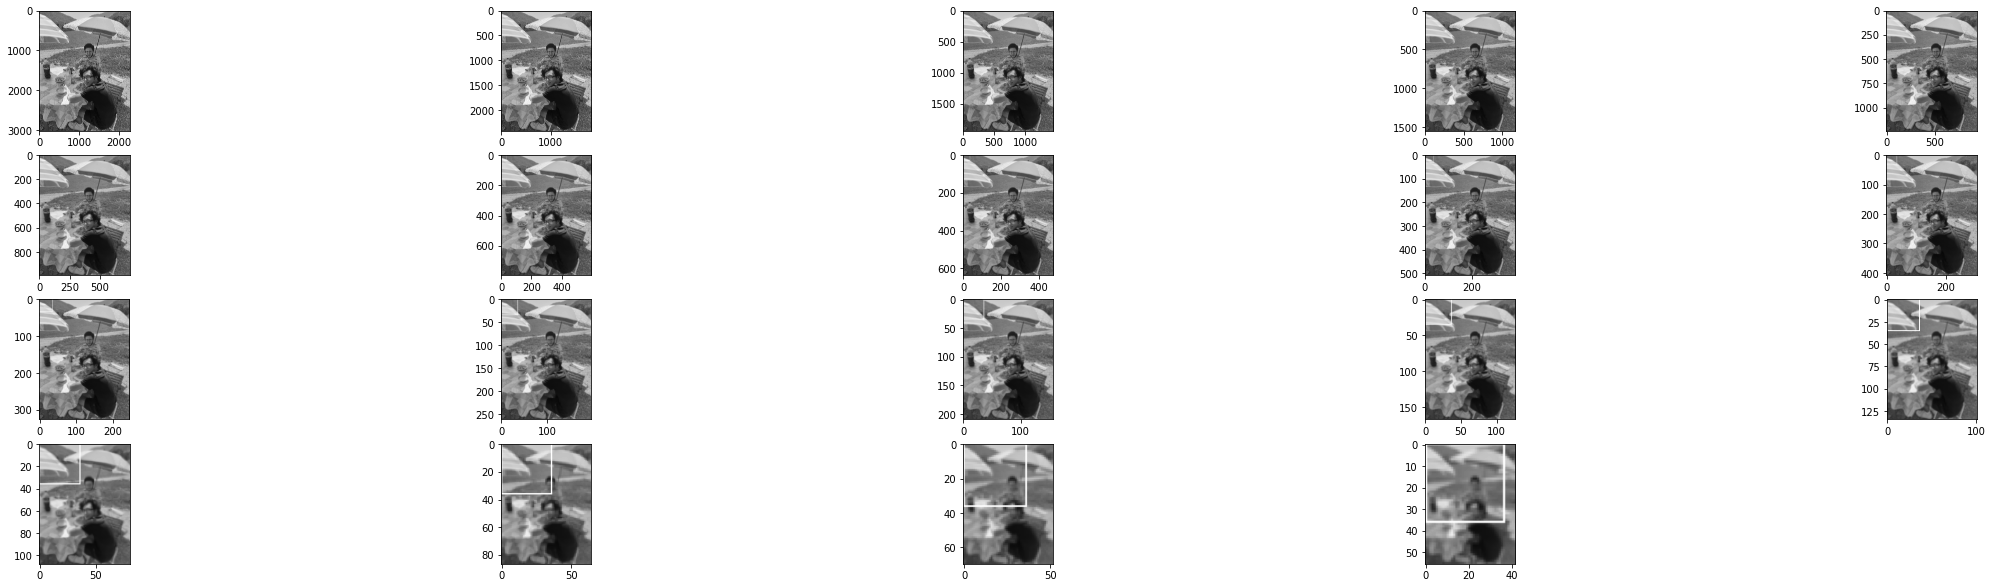

In [11]:
fig = plt.figure(figsize=(40, 50))
rows = math.ceil(len(images))
cols = 5

for i in range(0, len(images)):
    # Adds a subplot at the 1st position
    fig.add_subplot(rows, cols, i+1)
    
    # showing image
    image = images[i].permute(1, 2, 0).numpy()
    image = (image*0.5 + 0.5)*255
    image = image.astype(np.uint8) # cv rectangle only accepts np.uint8 https://stackoverflow.com/questions/71762449/error-opencv4-5-4-1-error-5bad-argument-in-function-gaussianblur
    cv.rectangle(image, (0,0), (36, 36), (255,255,255))
    plt.imshow(image, cmap='gray', vmin=0, vmax=255)

plt.show()

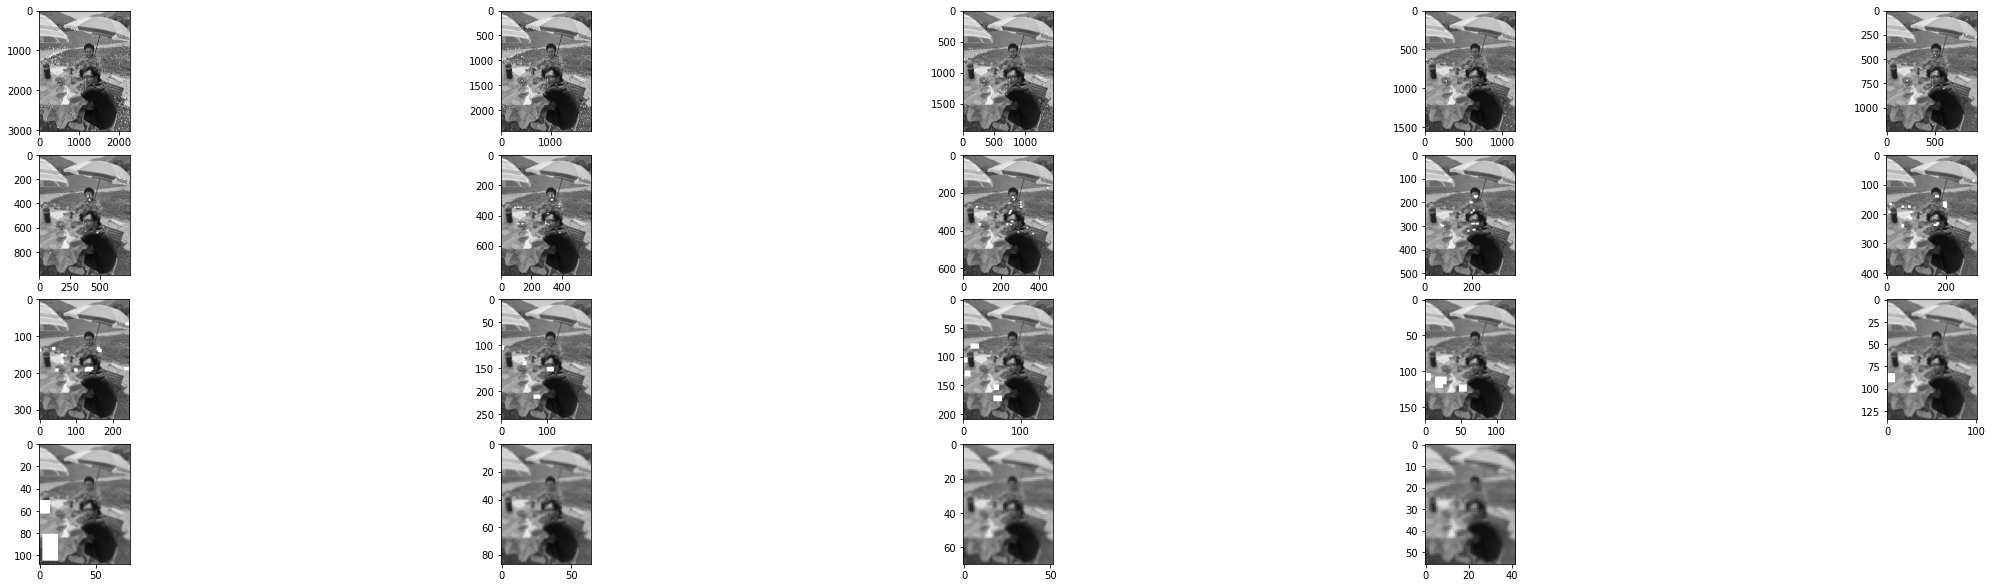

In [12]:
fig = plt.figure(figsize=(40, 50))
rows = math.ceil(len(images))
cols = 5

height = transformed_image.size()[1]
width = transformed_image.size()[2]
merge_feature = torch.zeros([1, height, width], dtype=torch.int64)

for i in range(0, len(images)):
    image = images[i]

    # Adds a subplot at the 1st position
    fig.add_subplot(rows, cols, i+1)
    
    # feature_map
    feature = torch.tensor(feature_maps[i])
    feature = feature.reshape((1, feature.size()[0], feature.size()[1]))
    feature = T.Resize((image.size()[1], image.size()[2]), interpolation=InterpolationMode.BILINEAR)(feature)

    fs_feature = T.Resize((height, width), interpolation=InterpolationMode.BILINEAR)(feature)
    merge_feature = merge_feature + fs_feature
    
    # merge_feature = merge_feature + feature

    feature = feature.permute(1, 2, 0).numpy()
    feature = feature*255
    feature = np.clip(feature, 0, 255)
    feature = feature.astype(np.uint8)


    # image
    image = image.permute(1, 2, 0).numpy()
    image = (image*0.5 + 0.5)*255
    
    image = image + feature
    image = np.clip(image, 0, 255)

    image = image.astype(np.uint8) # cv rectangle only accepts np.uint8 https://stackoverflow.com/questions/71762449/error-opencv4-5-4-1-error-5bad-argument-in-function-gaussianblur

    plt.imshow(image, cmap='gray', vmin=0, vmax=255)

merge_feature = merge_feature * 255
merge_feature = merge_feature.permute(1, 2, 0).numpy()
merge_feature = np.clip(merge_feature, 0, 255)

plt.show()

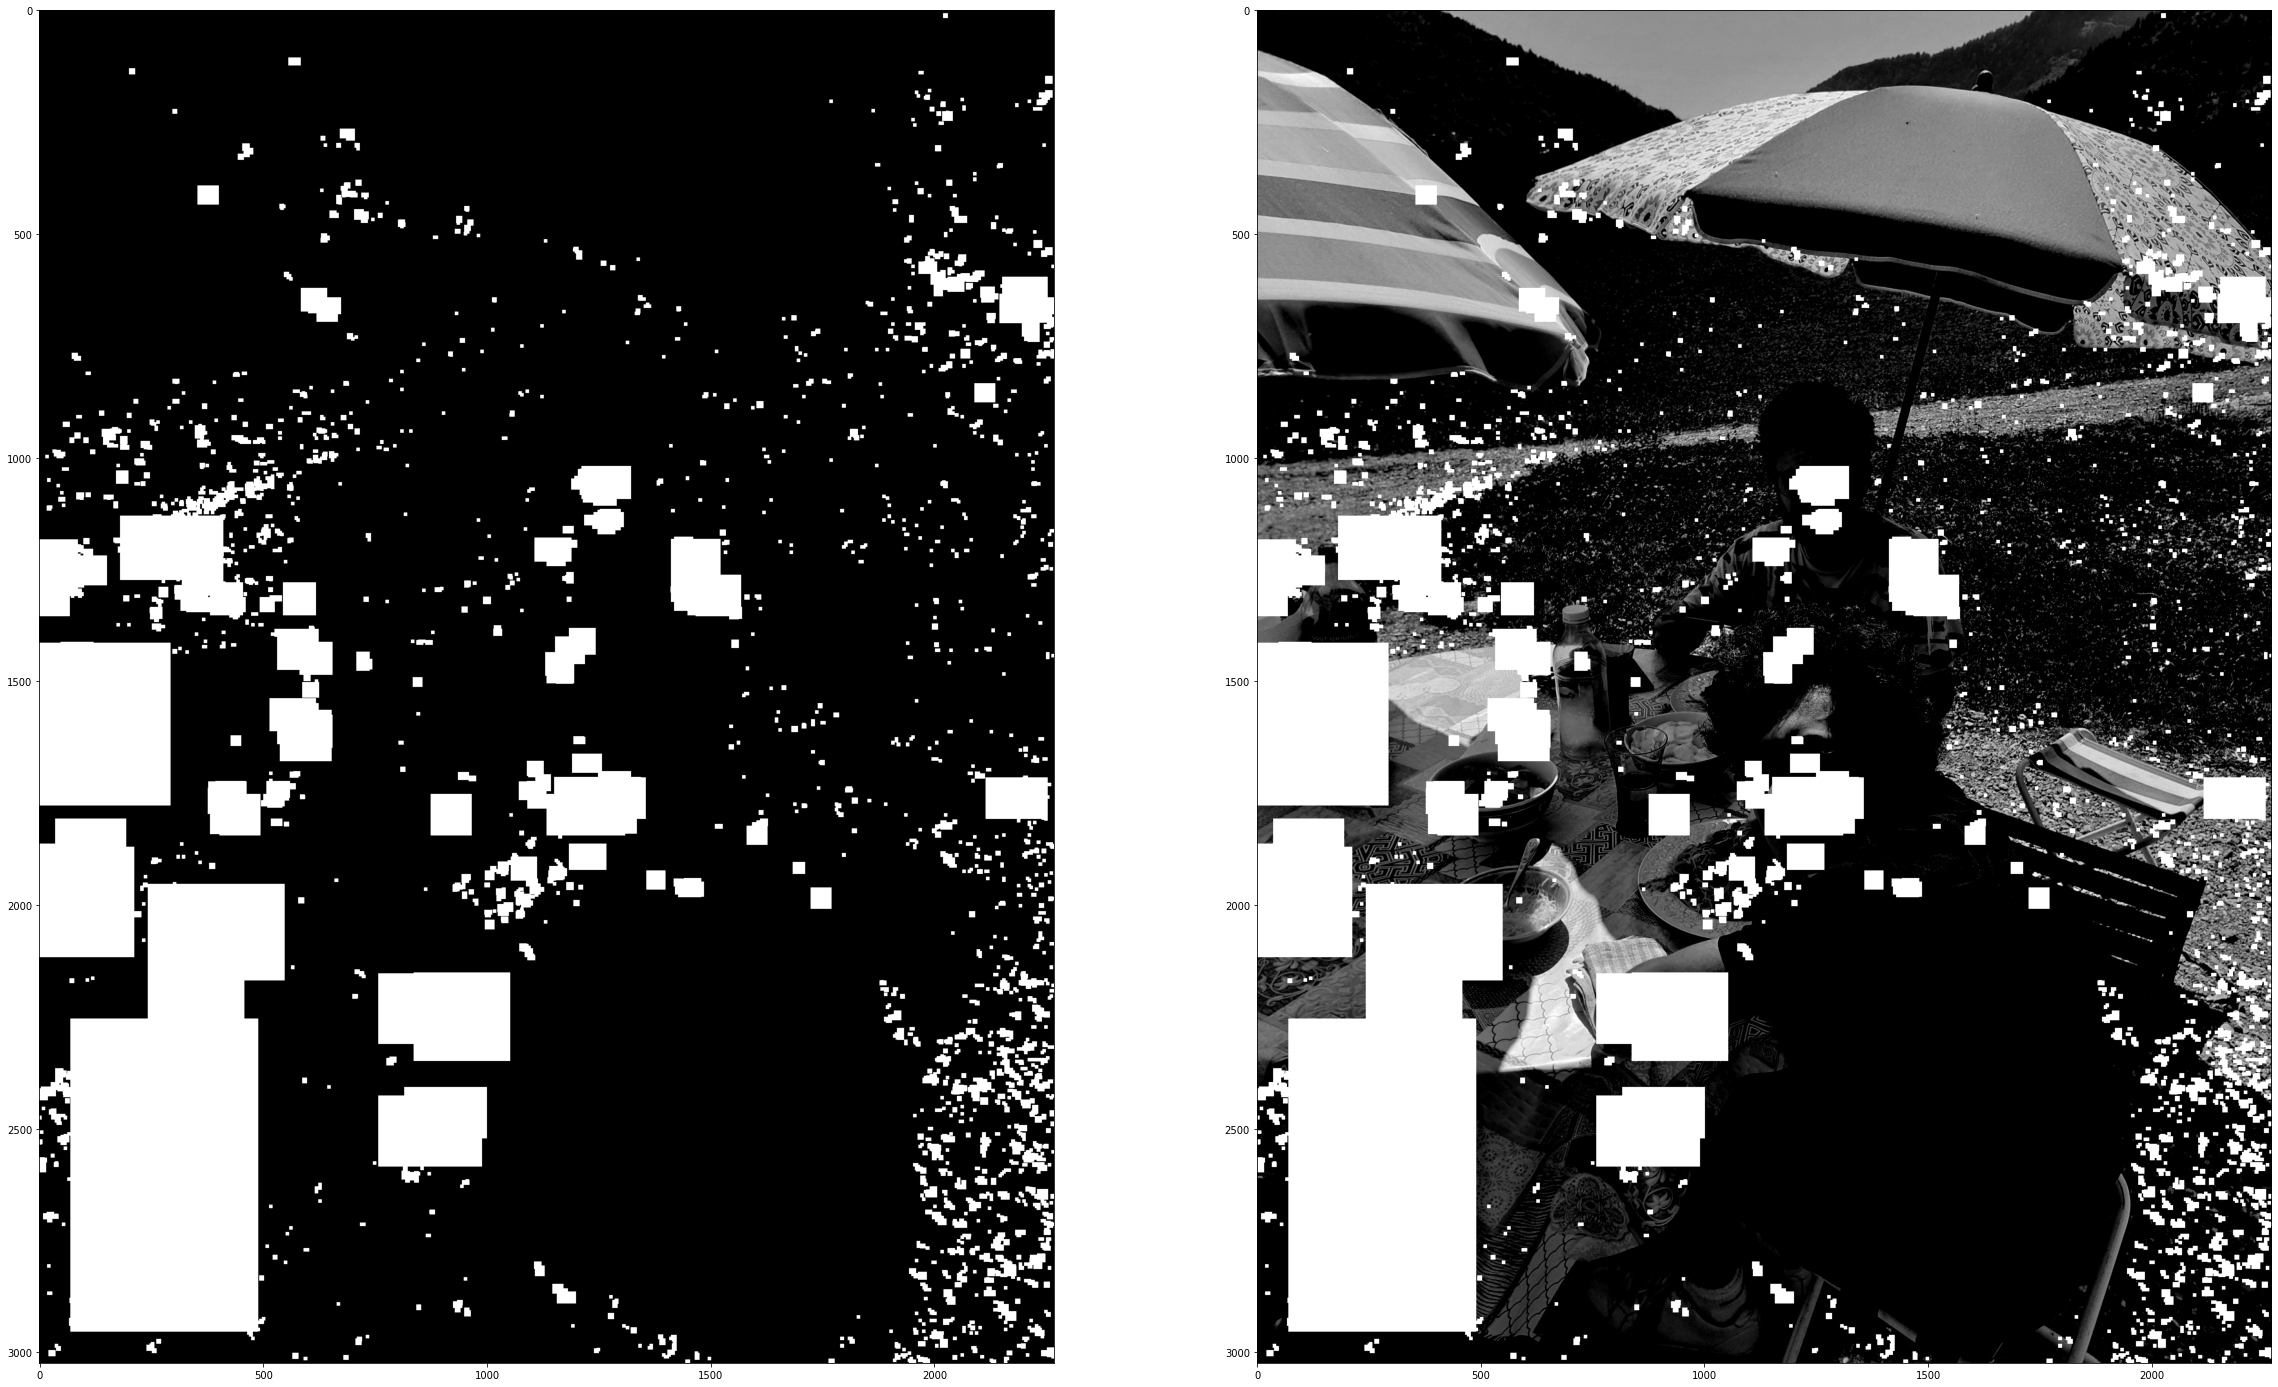

In [13]:
fig = plt.figure(figsize=(40, 50))
rows = 1
cols = 2

fig.add_subplot(rows, cols, 1)
plt.imshow(merge_feature, cmap='gray', vmin=0, vmax=255)

merge_image = transformed_image.clone().permute(1, 2, 0).numpy()*255

merge_image = np.clip(merge_image + merge_feature*255, 0, 255)

fig.add_subplot(rows, cols, 2)
plt.imshow(merge_image, cmap='gray', vmin=0, vmax=255)

plt.show()

In [14]:
# cv.imshow("Display window", img_color)
# k = cv.waitKey(0)
# cv.destroyAllWindows()